In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StandardScaler, VectorAssembler
from pyspark.sql import SparkSession, functions as F, types
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
#import org.apache.log4j.{Level, Logger}



Iniciamos la sesion spark

In [2]:
sparkConf = SparkSession\
        .builder\
        .appName("Spark ML Clustering")\
        .getOrCreate()

Texto

In [3]:
#logger = sparkConf._jvm.org.apache.log4j
#logger.LogManager.getLogger("org").setLevel(logger.Level.WARN)
#logger.LogManager.getLogger("org").setLevel(logger.Level.INFO)

 

Cargamos los datos del archivo csv

In [3]:
    # Loads data
    chicago_raw= sparkConf\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("crimes.csv")
        #.load(sys.argv[1])

Mostramos el dataset

In [4]:
chicago_raw=chicago_raw.select("ID","Date","Primary Type","Arrest","Domestic","District","Latitude","Longitude")

Ahora con Timestamp lo que tenemos en la columna de fecha es el numero de milisegundos desde el 1 de enero de 1970

In [5]:
chicago_raw = chicago_raw.withColumn("Date", F.to_timestamp(F.unix_timestamp("Date", "M/dd/yyyy hh:mm:ss a").cast("timestamp")))

In [ ]:
Lo pasamos a tipo fecha

In [6]:
chicago_raw = chicago_raw.withColumn("Date", F.to_date(F.unix_timestamp("Date", "M/dd/yyyy hh:mm:ss a").cast("timestamp")))

In [8]:
chicago_raw.show(10)

+--------+----------+------------------+------+--------+--------+------------+-------------+
|      ID|      Date|      Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|
+--------+----------+------------------+------+--------+--------+------------+-------------+
|10224738|2015-09-05|           BATTERY| false|    true|     009|41.815117282|-87.669999562|
|10224739|2015-09-04|             THEFT| false|   false|     015|41.895080471|-87.765400451|
|11646166|2018-09-01|             THEFT| false|    true|     006|        null|         null|
|10224740|2015-09-05|         NARCOTICS|  true|   false|     014|41.937405765|-87.716649687|
|10224741|2015-09-05|           ASSAULT| false|    true|     015|41.881903443|-87.755121152|
|10224742|2015-09-05|          BURGLARY| false|   false|     006|41.744378879|-87.658430635|
|10224743|2015-09-04|          BURGLARY| false|   false|     014|41.914635603|-87.681630909|
|10224744|2015-09-05|             THEFT|  true|   false|     010|41.85

Quitamos las filas con valores nulos del dataset

In [7]:
chicago_raw=chicago_raw.na.drop()

Exploramos la forma y el tamaño del dataframe con el que vamos a trabajar

In [8]:
chicago_raw.show(10)

+--------+----------+------------+------+--------+--------+------------+-------------+
|      ID|      Date|Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|
+--------+----------+------------+------+--------+--------+------------+-------------+
|10224738|2015-09-05|     BATTERY| false|    true|     009|41.815117282|-87.669999562|
|10224739|2015-09-04|       THEFT| false|   false|     015|41.895080471|-87.765400451|
|10224740|2015-09-05|   NARCOTICS|  true|   false|     014|41.937405765|-87.716649687|
|10224741|2015-09-05|     ASSAULT| false|    true|     015|41.881903443|-87.755121152|
|10224742|2015-09-05|    BURGLARY| false|   false|     006|41.744378879|-87.658430635|
|10224743|2015-09-04|    BURGLARY| false|   false|     014|41.914635603|-87.681630909|
|10224744|2015-09-05|       THEFT|  true|   false|     010|41.851988885|-87.689219118|
|10224745|2015-09-05|     ROBBERY| false|    true|     012| 41.88281374|-87.704325717|
|10224746|2015-09-05|       THEFT| false|  

In [49]:
chicago_raw.count()

7358359

Cambiamos el tipo de las columnas Latitude y Longitude a double y las de Arrest y Domestic que son booleanas a entero 

In [9]:
chicago_raw = chicago_raw.withColumn("Latitude", chicago_raw["Latitude"].cast(types.DoubleType()))
chicago_raw = chicago_raw.withColumn("Longitude", chicago_raw["Longitude"].cast(types.DoubleType()))
chicago_raw = chicago_raw.withColumn("Arrest", chicago_raw["Arrest"].cast(types.BooleanType()))
chicago_raw = chicago_raw.withColumn("Domestic", chicago_raw["Domestic"].cast(types.BooleanType()))
chicago_raw = chicago_raw.withColumn("Arrest", chicago_raw["Arrest"].cast(types.IntegerType()))
chicago_raw = chicago_raw.withColumn("Domestic", chicago_raw["Domestic"].cast(types.IntegerType()))
chicago_raw.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Arrest: integer (nullable = true)
 |-- Domestic: integer (nullable = true)
 |-- District: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [10]:
chicago_raw.columns

assemble=VectorAssembler(inputCols=[

 #'Arrest',
 #'Domestic',

 'Latitude',
 'Longitude'], outputCol='features')

assembled_data=assemble.transform(chicago_raw)

assembled_data.show(2)

+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+
|      ID|      Date|Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|            features|
+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+
|10224738|2015-09-05|     BATTERY|     0|       1|     009|41.815117282|-87.669999562|[41.815117282,-87...|
|10224739|2015-09-04|       THEFT|     0|       0|     015|41.895080471|-87.765400451|[41.895080471,-87...|
+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+
only showing top 2 rows



In [11]:
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+--------------------+
|      ID|      Date|Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|            features|        standardized|
+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+--------------------+
|10224738|2015-09-05|     BATTERY|     0|       1|     009|41.815117282|-87.669999562|[41.815117282,-87...|[470.841491664678...|
|10224739|2015-09-04|       THEFT|     0|       0|     015|41.895080471|-87.765400451|[41.895080471,-87...|[471.741883428095...|
+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+--------------------+
only showing top 2 rows



In [12]:
data_scale_output.show(10)

+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+--------------------+
|      ID|      Date|Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|            features|        standardized|
+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+--------------------+
|10224738|2015-09-05|     BATTERY|     0|       1|     009|41.815117282|-87.669999562|[41.815117282,-87...|[470.841491664678...|
|10224739|2015-09-04|       THEFT|     0|       0|     015|41.895080471|-87.765400451|[41.895080471,-87...|[471.741883428095...|
|10224740|2015-09-05|   NARCOTICS|     1|       0|     014|41.937405765|-87.716649687|[41.937405765,-87...|[472.218469549514...|
|10224741|2015-09-05|     ASSAULT|     0|       1|     015|41.881903443|-87.755121152|[41.881903443,-87...|[471.593509062016...|
|10224742|2015-09-05|    BURGLARY|     0|       0|     006|41.744378879|-87.658430635|[41.7443788

In [13]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='standardized').setK(6).setSeed(1)
model = kmeans.fit(data_scale_output)

# Make predictions
predictions = model.transform(data_scale_output)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
     print(center)

Silhouette with squared euclidean distance = 0.48261223844127127
Cluster Centers: 
[  471.9564873  -1436.11499715]
[  469.87760278 -1434.41555819]
[  412.33783104 -1500.60398298]
[  472.03282339 -1434.68056177]
[  470.75754884 -1435.31146918]
[  470.3224221  -1433.60216017]


In [ ]:
#Tenemos que estudiar como se está calculando el evaluador, si es mejor bajo o alto y utilizar la distancia a Manhattan
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    #KMeans_algo=KMeans(featuresCol='standardized', k=2)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.6434046329356482
Silhouette Score: 0.5593517933164313
Silhouette Score: 0.5996666283991192
Silhouette Score: 0.562266259462373
Silhouette Score: 0.5472363585069596


ValueError: x and y must have same first dimension, but have shapes (8,) and (1,)

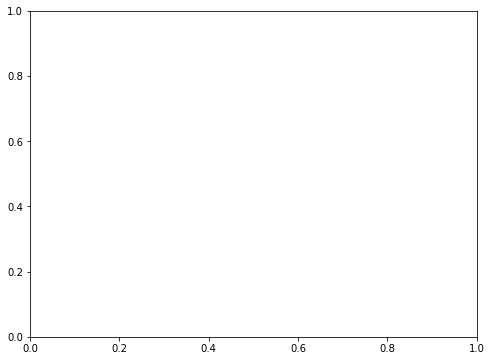

In [16]:
#Visualizing the silhouette scores in a plot

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [18]:
predictions.show(10)

+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+--------------------+----------+
|      ID|      Date|Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|            features|        standardized|prediction|
+--------+----------+------------+------+--------+--------+------------+-------------+--------------------+--------------------+----------+
|10224738|2015-09-05|     BATTERY|     0|       1|     009|41.815117282|-87.669999562|[41.815117282,-87...|[470.841491664678...|         4|
|10224739|2015-09-04|       THEFT|     0|       0|     015|41.895080471|-87.765400451|[41.895080471,-87...|[471.741883428095...|         0|
|10224740|2015-09-05|   NARCOTICS|     1|       0|     014|41.937405765|-87.716649687|[41.937405765,-87...|[472.218469549514...|         0|
|10224741|2015-09-05|     ASSAULT|     0|       1|     015|41.881903443|-87.755121152|[41.881903443,-87...|[471.593509062016...|         0|
|10224742|2015-09-05

In [19]:
predictions_processed1 = predictions[['ID','Primary Type','Arrest','Domestic','prediction']]

In [20]:
predictions_processed1.show(10)

+--------+------------+------+--------+----------+
|      ID|Primary Type|Arrest|Domestic|prediction|
+--------+------------+------+--------+----------+
|10224738|     BATTERY|     0|       1|         4|
|10224739|       THEFT|     0|       0|         0|
|10224740|   NARCOTICS|     1|       0|         0|
|10224741|     ASSAULT|     0|       1|         0|
|10224742|    BURGLARY|     0|       0|         1|
|10224743|    BURGLARY|     0|       0|         3|
|10224744|       THEFT|     1|       0|         4|
|10224745|     ROBBERY|     0|       1|         0|
|10224746|       THEFT|     0|       0|         4|
|10224749|     BATTERY|     0|       0|         0|
+--------+------------+------+--------+----------+
only showing top 10 rows



In [26]:
predictions_processed1.write.csv("C:/Users/dario/Work/Universidad/1.Master/3.Semestre/3.Big_Data/Resultados/predictionsProcessed1.csv")

In [21]:
predictions_processed1=predictions_processed1.groupBy('Primary Type','Arrest','Domestic','prediction') \
.count() \
.alias('num_crimes') \

+--------------------+------+--------+----------+-----+
|        Primary Type|Arrest|Domestic|prediction|count|
+--------------------+------+--------+----------+-----+
|          KIDNAPPING|     1|       0|         0|  143|
|        NON-CRIMINAL|     1|       0|         1|    1|
|            GAMBLING|     0|       0|         5|   30|
|             ASSAULT|     0|       0|         3|56731|
|      NON - CRIMINAL|     0|       0|         3|    4|
|        PROSTITUTION|     1|       0|         4|13385|
|            GAMBLING|     1|       0|         5| 2781|
|       OTHER OFFENSE|     1|       0|         5|12038|
|       OTHER OFFENSE|     1|       0|         1|11785|
|PUBLIC PEACE VIOL...|     0|       0|         5| 2568|
+--------------------+------+--------+----------+-----+
only showing top 10 rows



In [22]:
predictions_processed1.show(10)

+--------+------------+------+--------+----------+
|      ID|Primary Type|Arrest|Domestic|prediction|
+--------+------------+------+--------+----------+
|10224738|     BATTERY|     0|       1|         4|
|10224739|       THEFT|     0|       0|         0|
|10224740|   NARCOTICS|     1|       0|         0|
|10224741|     ASSAULT|     0|       1|         0|
|10224742|    BURGLARY|     0|       0|         1|
|10224743|    BURGLARY|     0|       0|         3|
|10224744|       THEFT|     1|       0|         4|
|10224745|     ROBBERY|     0|       1|         0|
|10224746|       THEFT|     0|       0|         4|
|10224749|     BATTERY|     0|       0|         0|
+--------+------------+------+--------+----------+
only showing top 10 rows



Agregamos el dataframe para trabajar con algo más ligero y manejable. Esto nos permite un desarrollo más ágil y menor tiempo de computo de cada celda posterior.

In [42]:
predictions_processed1 = predictions_processed1.groupBy('Primary Type','Arrest','Domestic','prediction') \
.count() \
.withColumnRenamed("count","num_crimes")

In [43]:
predictions_processed1.show(10)

+--------------------+------+--------+----------+----------+
|        Primary Type|Arrest|Domestic|prediction|num_crimes|
+--------------------+------+--------+----------+----------+
|          KIDNAPPING|     1|       0|         0|       143|
|        NON-CRIMINAL|     1|       0|         1|         1|
|            GAMBLING|     0|       0|         5|        30|
|             ASSAULT|     0|       0|         3|     56731|
|      NON - CRIMINAL|     0|       0|         3|         4|
|        PROSTITUTION|     1|       0|         4|     13385|
|            GAMBLING|     1|       0|         5|      2781|
|       OTHER OFFENSE|     1|       0|         5|     12038|
|       OTHER OFFENSE|     1|       0|         1|     11785|
|PUBLIC PEACE VIOL...|     0|       0|         5|      2568|
+--------------------+------+--------+----------+----------+
only showing top 10 rows



In [44]:
predictions_processed1.count()

615

Empezamos a dibujar los poligonos

In [45]:
poligonos=predictions[['prediction','Latitude','Longitude']]
poligonos.show(10)

+----------+------------+-------------+
|prediction|    Latitude|    Longitude|
+----------+------------+-------------+
|         4|41.815117282|-87.669999562|
|         0|41.895080471|-87.765400451|
|         0|41.937405765|-87.716649687|
|         0|41.881903443|-87.755121152|
|         1|41.744378879|-87.658430635|
|         3|41.914635603|-87.681630909|
|         4|41.851988885|-87.689219118|
|         0| 41.88281374|-87.704325717|
|         4|41.763647552|-87.722344693|
|         0|41.975968415|-87.768014257|
+----------+------------+-------------+
only showing top 10 rows



In [46]:
poligonos.count()

7358359

In [47]:
poligonos_processed = poligonos.groupBy('prediction','Latitude','Longitude') \
.count() \
.withColumnRenamed("count","num_crimes")

In [48]:
poligonos_processed.count()

880735